# 📊 Desembolsos Mensais - BNDES
Projeto Semantix | EBAC

O desembolso do BNDES é o valor total de recursos liberados pelo Banco Nacional de Desenvolvimento Econômico e Social (BNDES), e podem ser classificados de acordo com a finalidade dos investimentos.

O dataset contém dados sobre os desembolsos feitos pelo banco, informando forma de apoio, porte da empresa e um indicador de **Inovação**, variável que demonstra se o repasse teve como objetivo, ou não, um elemento inovador.

**Objetivo:**
Treinar um modelo de classificação com foco em identificar fatores que explicam o _indicador de inovação_, ou seja, quais características influenciam a variável ``inovacao``.


- **Fonte do Dataset:** [Desembolsos Mensais - BNDES](https://dadosabertos.bndes.gov.br/dataset/desembolsos-mensais)
- **Sobre Inovação - BNDES:** [Inovação - BNDES](https://www.bndes.gov.br/wps/portal/site/home/onde-atuamos/inovacao/inovacao)

## Dicionário dos Dados

| Nome                     | Tipo     | Descrição |
|--------------------------|---------|-----------|
| Ano                      | int64   | Ano da liberação. |
| Mês                      | int64   | Mês da liberação. |
| Forma de apoio           | string  | O cliente pode solicitar o financiamento diretamente ao BNDES (forma direta) ou por meio de instituições financeiras credenciadas (forma indireta). A forma de apoio depende da finalidade e do valor do financiamento. |
| Produto                  | string  | Produtos definem regras gerais de financiamento de acordo com cada finalidade. Cada produto pode se dividir em instrumentos financeiros diferentes, que atendem a tipos de clientes e objetivos diferentes, com condições específicas (como taxa de juros e prazo de pagamento). |
| Instrumento financeiro   | string  | Pode ser classificado em linhas, programas e fundos. Linhas de financiamento visam atender as demandas permanentes de apoio; programas visam atender a demanda específica, apresentando prazo de vigência e dotação previamente estabelecidos; e fundos podem ter natureza estatutária ou legal e são regidos por normas próprias, que definem suas condições específicas. |
| Inovação                 | string  | Indicador de inovação, no qual são considerados os instrumentos financeiros que têm por objetivo o apoio à inovação. |
| Porte da empresa         | string  | Considerado o porte da empresa de acordo com a política de classificação do BNDES vigente na época. |
| Região                   | string  | Região onde o investimento foi realizado ou o cliente está registrado. |
| UF                       | string  | Unidade federativa onde o investimento foi realizado ou o cliente está registrado. |
| Município                | string  | Município onde o investimento foi realizado ou o ente público está registrado. |
| Município - código       | string  | Código do município onde o investimento foi realizado ou o ente público está registrado. |
| Setor CNAE               | string  | Agrupamento utilizado pelo BNDES para fins estatísticos. Este agrupamento leva em consideração os códigos CNAEs. Pode-se identificar a correspondência do Setor CNAE e os códigos da classificação CNAE 2.2. do IBGE através da planilha DE-PARA CNAE. |
| Subsetor CNAE agrupado   | string  | Agrupamento utilizado pelo BNDES para fins estatísticos. Este agrupamento leva em consideração os códigos CNAEs. Pode-se identificar a correspondência do Subsetor CNAE Agrupado e os códigos da classificação CNAE 2.2. do IBGE através da planilha DE-PARA CNAE. |
| Setor BNDES              | string  | Agrupamento utilizado pelo BNDES para fins estatísticos. Este agrupamento leva em consideração os códigos CNAEs e os produtos do BNDES. Pode-se identificar a correspondência do Setor BNDES e a seção da classificação CNAE 2.2. do IBGE através da planilha DE-PARA CNAE. |
| Subsetor BNDES           | string  | Agrupamento utilizado pelo BNDES para fins estatísticos. Este agrupamento leva em consideração os códigos CNAEs e os produtos do BNDES. Pode-se identificar a correspondência do Subsetor BNDES e a seção da classificação CNAE 2.2. do IBGE através da planilha DE-PARA CNAE. |
| Desembolsos (R$)         | float64 | Valor da liberação em Reais. |


In [2]:
%%time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

CPU times: total: 0 ns
Wall time: 0 ns


## 1. Entendimento dos Dados

**Coleta:** O dataset original contém mais de 3 milhões de linhas, por ser muito grande optei por selecionar aleatoriamente 800.000 linhas.

Vale lembrar, eu testei o código com o original e não houve muitas mudanças nos resultados em relação ao dataset selecionado.

In [6]:
%%time
# pd.read_csv('desembolsos-mensais.csv', sep = ';').sample(800000).to_csv('dados_desembolso.csv', index=False)

CPU times: total: 0 ns
Wall time: 0 ns


In [7]:
df = pd.read_csv('dados_desembolso.csv')
df.head(2)

,ano,mes,forma_de_apoio,produto,instrumento_financeiro,inovacao,porte_de_empresa,regiao,uf,municipio,municipio_codigo,setor_cnae,subsetor_cnae_agrupado,setor_bndes,subsetor_bndes,desembolsos_reais
0,"2013,0",11,INDIRETA,CARTÃO BNDES,CARTÃO BNDES,NÃO,PEQUENA,NORTE,PARA,SAO DOMINGOS DO CAPIM,"1507201,0",COMÉRCIO E SERVIÇOS,COMÉRCIO,COMÉRCIO E SERVIÇOS,COMÉRCIO E SERVIÇOS,"7245,06"
1,"2011,0",4,INDIRETA,CARTÃO BNDES,CARTÃO BNDES,NÃO,MICRO,NORTE,ACRE,XAPURI,"1200708,0",INDÚSTRIA DE TRANSFORMAÇÃO,PRODUTOS ALIMENTÍCIOS,INDUSTRIA,ALIMENTO E BEBIDA,"3722,98"


In [8]:
f'O dataframe contém {df.shape[0]} linhas e {df.shape[1]} linhas e colunas.'

'O dataframe contém 800000 linhas e 16 linhas e colunas.'

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ano                     800000 non-null  object
 1   mes                     800000 non-null  int64 
 2   forma_de_apoio          800000 non-null  object
 3   produto                 800000 non-null  object
 4   instrumento_financeiro  753030 non-null  object
 5   inovacao                753030 non-null  object
 6   porte_de_empresa        800000 non-null  object
 7   regiao                  800000 non-null  object
 8   uf                      800000 non-null  object
 9   municipio               800000 non-null  object
 10  municipio_codigo        800000 non-null  object
 11  setor_cnae              800000 non-null  object
 12  subsetor_cnae_agrupado  800000 non-null  object
 13  setor_bndes             800000 non-null  object
 14  subsetor_bndes          800000 non-n

### 1.1. Análise Exploratória de Dados (EDA)
No entendimento inicial dos dados, percebe-se que colunas que deveriam ser numéricas são object. Então para fazer um resumo estatístico converti o tipo. Em seguida faço uma análise descritiva das variáveis.

In [11]:
pd.set_option('display.float_format', '{:.2f}'.format)

df['ano'] = df['ano'].str.replace(',', '').astype('int64')

df['desembolsos_reais'] = df['desembolsos_reais'].str.replace(',', '.').astype('float64')
df['desembolsos_reais'].describe()

count       800000.00
mean        645995.81
std       15049267.19
min              0.01
25%          18952.72
50%          72384.50
75%         222070.95
max     9409998497.06
Name: desembolsos_reais, dtype: float64

In [12]:
# Visão geral dos dados
print("\nResumo estatístico das variáveis categóricas:")
df.describe(include=['O'])


Resumo estatístico das variáveis categóricas:


,forma_de_apoio,produto,instrumento_financeiro,inovacao,porte_de_empresa,regiao,uf,municipio,municipio_codigo,setor_cnae,subsetor_cnae_agrupado,setor_bndes,subsetor_bndes
count,800000,800000,753030,753030,800000,800000,800000,800000,800000,800000,800000,800000,800000
unique,2,12,237,2,4,5,27,5212,5490,4,45,4,20
top,INDIRETA,CARTÃO BNDES,CARTÃO BNDES,NÃO,MICRO,SUDESTE,SAO PAULO,DIVERSOS,"3550308,0",COMÉRCIO E SERVIÇOS,AGROPECUÁRIA,COMÉRCIO E SERVIÇOS,COMÉRCIO E SERVIÇOS
freq,788060,327114,327114,749566,459740,297235,158775,12186,9615,415836,196896,292450,292450


In [13]:
# Valores únicos em colunas categóricas
print("\nValores únicos por coluna categórica:\n")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()}")


Valores únicos por coluna categórica:

forma_de_apoio: 2
produto: 12
instrumento_financeiro: 237
inovacao: 2
porte_de_empresa: 4
regiao: 5
uf: 27
municipio: 5212
municipio_codigo: 5490
setor_cnae: 4
subsetor_cnae_agrupado: 45
setor_bndes: 4
subsetor_bndes: 20


In [14]:
# Verificação de valores ausentes
print(f'Valores ausentes:\n{df.isna().sum()}')

Valores ausentes:
ano                           0
mes                           0
forma_de_apoio                0
produto                       0
instrumento_financeiro    46970
inovacao                  46970
porte_de_empresa              0
regiao                        0
uf                            0
municipio                     0
municipio_codigo              0
setor_cnae                    0
subsetor_cnae_agrupado        0
setor_bndes                   0
subsetor_bndes                0
desembolsos_reais             0
dtype: int64


In [15]:
# Verificação de registros duplicados
duplicates = df.duplicated().sum()
print(f"Total de registros duplicados: {duplicates}")

Total de registros duplicados: 0


In [16]:
# Verificação de inconsistências em variáveis categóricas
print("Contagem de valores únicos de algumas colunas categóricas para checar inconsistências:\n")

categoricas = ['forma_de_apoio', 'produto', 'inovacao', 'porte_de_empresa', 'regiao', 'setor_cnae', 'setor_bndes']

for col in categoricas:
    # print(f"\n")
    print(df[col].value_counts(),"\n")

Contagem de valores únicos de algumas colunas categóricas para checar inconsistências:

forma_de_apoio
INDIRETA    788060
DIRETA       11940
Name: count, dtype: int64 

produto
CARTÃO BNDES                   327114
BNDES FINAME                   299920
BNDES AUTOMÁTICO               156390
BNDES FINEM                     10423
BNDES-EXIM                       2180
BNDES NÃO REEMBOLSÁVEL           1789
BNDES CRÉDITO RURAL              1547
BNDES MERCADO DE CAPITAIS         589
BNDES MICROCRÉDITO                 25
BNDES OUTROS PRODUTOS              17
BNDES MÉDIAS EMPRESAS               5
BNDES PRESTAÇÃO DE GARANTIA         1
Name: count, dtype: int64 

inovacao
NÃO    749566
SIM      3464
Name: count, dtype: int64 

porte_de_empresa
MICRO      459740
PEQUENA    189332
MÉDIA       88258
GRANDE      62670
Name: count, dtype: int64 

regiao
SUDESTE         297235
SUL             295044
NORDESTE         96164
CENTRO OESTE     75490
NORTE            36067
Name: count, dtype: int64 

setor_c

In [17]:
df.groupby('forma_de_apoio')['desembolsos_reais'].mean()

forma_de_apoio
DIRETA     19701314.81
INDIRETA     357286.19
Name: desembolsos_reais, dtype: float64

### 1.2. Gráficos

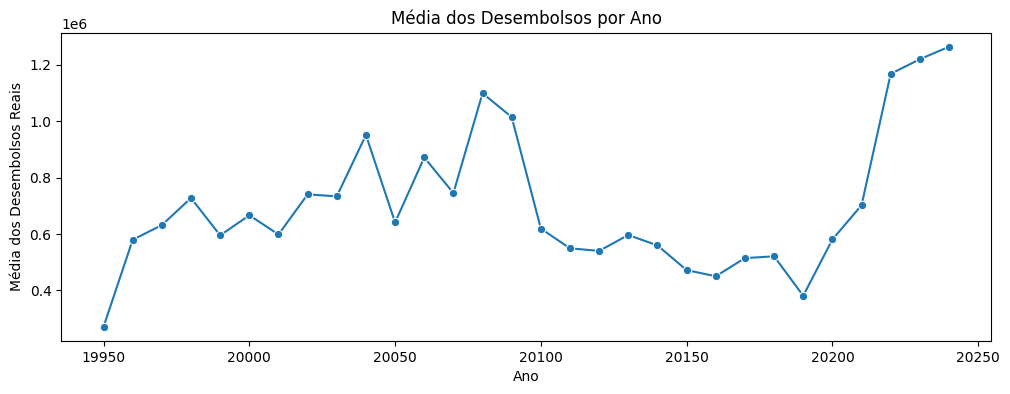

In [19]:
# Evolução de desembolso pelos anos
df_grouped = df.groupby('ano')['desembolsos_reais'].mean().reset_index()

plt.figure(figsize=(12, 4))
sns.lineplot(data=df_grouped, x='ano', y='desembolsos_reais', marker='o')

plt.xlabel('Ano')
plt.ylabel('Média dos Desembolsos Reais')
plt.title('Média dos Desembolsos por Ano')
plt.show()

C:\Users\Adrielle\AppData\Local\Temp\ipykernel_10836\678991582.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=25, ha="right")


[Text(0, 0, 'COMÉRCIO E SERVIÇOS'),
 Text(1, 0, 'INDÚSTRIA DE TRANSFORMAÇÃO'),
 Text(2, 0, 'AGROPECUÁRIA'),
 Text(3, 0, 'INDÚSTRIA EXTRATIVA')]

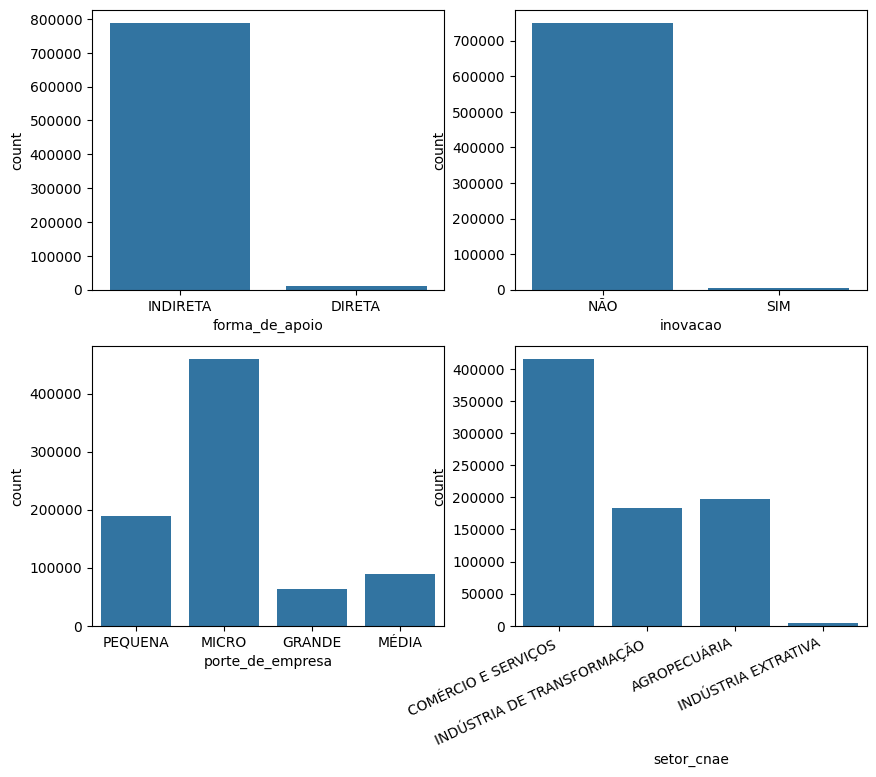

In [20]:
plt.close('all')
plt.rc('figure', figsize=(10, 8))
fig, axes = plt.subplots(2, 2)

sns.countplot(ax = axes[0, 0], x='forma_de_apoio', data=df)
sns.countplot(ax = axes[0, 1], x='inovacao', data=df)
sns.countplot(ax = axes[1, 0], x='porte_de_empresa', data=df)
sns.countplot(ax = axes[1, 1], x='setor_cnae', data=df)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=25, ha="right")

**Relação de variáveis com o indicador de Inovação**

C:\Users\Adrielle\AppData\Local\Temp\ipykernel_10836\2928647879.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=25, ha="right")
C:\Users\Adrielle\AppData\Local\Temp\ipykernel_10836\2928647879.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=25, ha="right")


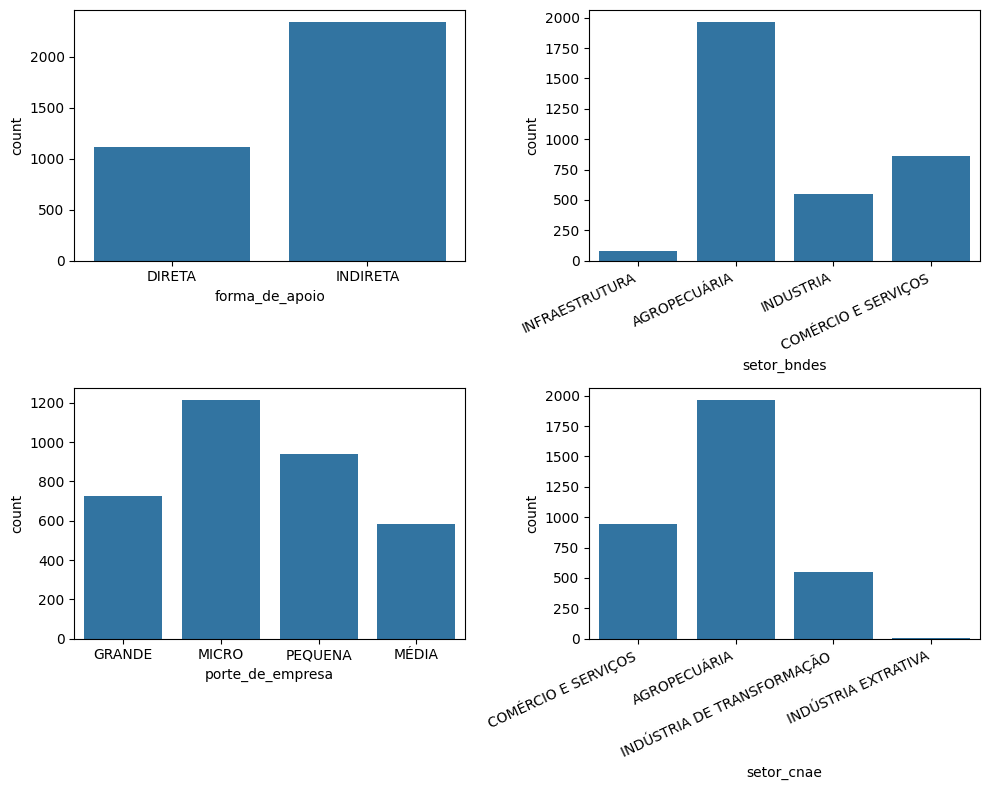

In [22]:
# Grafico com contagem em que essas variáveis tem o indicador de inovação

plt.close('all')
plt.rc('figure', figsize=(10, 8))

fig, axes = plt.subplots(2, 2)
df_filtrado = df[df['inovacao'] == "SIM"]

sns.countplot(ax=axes[0, 0], x='forma_de_apoio', data=df_filtrado)
sns.countplot(ax=axes[1, 0], x='porte_de_empresa', data=df_filtrado)
sns.countplot(ax=axes[0, 1], x='setor_bndes', data=df_filtrado)
sns.countplot(ax=axes[1, 1], x='setor_cnae', data=df_filtrado)

axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=25, ha="right")
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=25, ha="right")

plt.tight_layout()
plt.show()

Os plots demonstram a quantidade de _desembolso_ voltados para _inovação_ para as variáveis `forma_de_apoio`, `porte_de_empresa`, `setor_bndes`, `setor_bndes`.

## 2. Preparação dos Dados
Nesta etapa, foi necessário um profundo entendimento do outlier pois o dataset carrega valores bem distantens na coluna 'desembolsos_reais', o que já era esperado levando em consideração, principalmente, a variável `porte_de_empresa`.

A preparação para a modelagem passou, ainda, por tratamento e limpeza dos dados NaN.

In [25]:
#Selecionar dados
features = ['ano', 'mes', 'forma_de_apoio', 'produto',
            'instrumento_financeiro', 'inovacao', 
            'porte_de_empresa','regiao', 'setor_cnae',
            'setor_bndes','desembolsos_reais']

df2 = df[features].copy()
df2.head(3)

,ano,mes,forma_de_apoio,produto,instrumento_financeiro,inovacao,porte_de_empresa,regiao,setor_cnae,setor_bndes,desembolsos_reais
0,20130,11,INDIRETA,CARTÃO BNDES,CARTÃO BNDES,NÃO,PEQUENA,NORTE,COMÉRCIO E SERVIÇOS,COMÉRCIO E SERVIÇOS,7245.06
1,20110,4,INDIRETA,CARTÃO BNDES,CARTÃO BNDES,NÃO,MICRO,NORTE,INDÚSTRIA DE TRANSFORMAÇÃO,INDUSTRIA,3722.98
2,20150,9,INDIRETA,BNDES FINAME,PSI - BK - Demais Itens,NÃO,MICRO,SUDESTE,COMÉRCIO E SERVIÇOS,COMÉRCIO E SERVIÇOS,112000.00


In [26]:
df2.isna().sum()

ano                           0
mes                           0
forma_de_apoio                0
produto                       0
instrumento_financeiro    46970
inovacao                  46970
porte_de_empresa              0
regiao                        0
setor_cnae                    0
setor_bndes                   0
desembolsos_reais             0
dtype: int64

**Relação dos dados missing com os outros dados**

In [28]:
dfnan = df2[df2['instrumento_financeiro'].isna() | df2['inovacao'].isna()]
dfnan.head(3)

,ano,mes,forma_de_apoio,produto,instrumento_financeiro,inovacao,porte_de_empresa,regiao,setor_cnae,setor_bndes,desembolsos_reais
8,19990,9,INDIRETA,BNDES AUTOMÁTICO,NaN,NaN,MICRO,NORDESTE,INDÚSTRIA DE TRANSFORMAÇÃO,INDUSTRIA,42880.00
9,19980,8,INDIRETA,BNDES FINAME,NaN,NaN,MICRO,SUDESTE,AGROPECUÁRIA,AGROPECUÁRIA,4960.00
16,19950,1,INDIRETA,BNDES FINAME,NaN,NaN,MICRO,NORDESTE,AGROPECUÁRIA,AGROPECUÁRIA,97703.91


In [29]:
dfnan.isna().sum(),dfnan.shape

(ano                           0
 mes                           0
 forma_de_apoio                0
 produto                       0
 instrumento_financeiro    46970
 inovacao                  46970
 porte_de_empresa              0
 regiao                        0
 setor_cnae                    0
 setor_bndes                   0
 desembolsos_reais             0
 dtype: int64,
 (46970, 11))

In [30]:
"""df filtrado onde contém apenas nan nas colunas apresenta a mesma quantidade de nan do df original, ou seja, se tem nan em inovação tem em instrumento_financeiro.
Por isso a exclusão linhas."""

# Limpeza
df2 = df2.dropna()
df2.isna().sum().sum()

0

### 2.1. Identificando Outliers

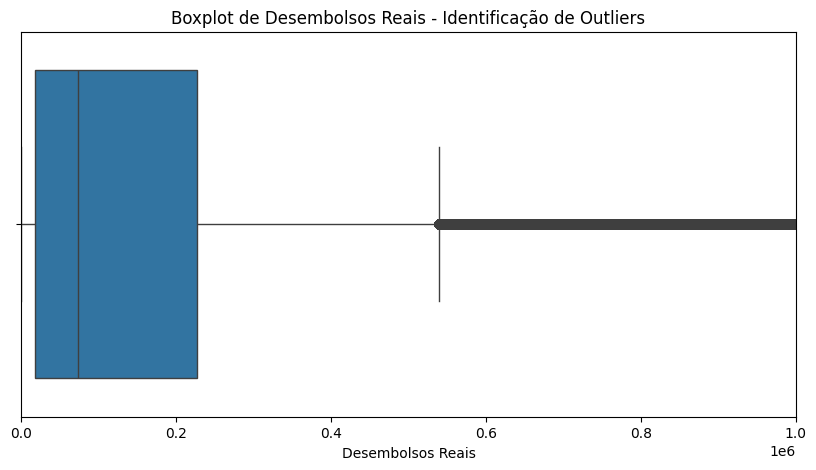

In [32]:
plt.figure(figsize=(10, 5))

sns.boxplot(x=df2['desembolsos_reais'])
plt.xlabel("Desembolsos Reais")
plt.title("Boxplot de Desembolsos Reais - Identificação de Outliers")
plt.xlim(0, 1000000)
plt.show()

In [33]:
# Calculando quartis
Q1 = df2['desembolsos_reais'].quantile(0.25)
Q3 = df2['desembolsos_reais'].quantile(0.75)
IQR = Q3 - Q1

# Definindo limites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrando outliers
outliers = df2[(df2['desembolsos_reais'] < limite_inferior) | (df2['desembolsos_reais'] > limite_superior)]
print("Outliers encontrados:")
outliers.shape

Outliers encontrados:


(87366, 11)

In [34]:
outliers.shape[0]/df2.shape[0]

0.11601928210031473

In [35]:
# Criar uma coluna indicando se um valor é outlier
df_outlier = df2.copy()
df_outlier['é_outlier'] = df_outlier['desembolsos_reais'] > limite_superior

# Contagem de outliers por categoria
for coluna in df_outlier.select_dtypes(include=['object']).columns:
    print(f"\nAnalisando {coluna}:")
    print(df_outlier.groupby(coluna)['é_outlier'].mean().sort_values(ascending=False))


Analisando forma_de_apoio:
forma_de_apoio
DIRETA     0.67
INDIRETA   0.11
Name: é_outlier, dtype: float64

Analisando produto:
produto
BNDES MICROCRÉDITO          0.92
BNDES-EXIM                  0.90
BNDES MÉDIAS EMPRESAS       0.80
BNDES MERCADO DE CAPITAIS   0.75
BNDES FINEM                 0.75
BNDES CRÉDITO RURAL         0.49
BNDES OUTROS PRODUTOS       0.47
BNDES NÃO REEMBOLSÁVEL      0.29
BNDES FINAME                0.20
BNDES AUTOMÁTICO            0.14
CARTÃO BNDES                0.01
Name: é_outlier, dtype: float64

Analisando instrumento_financeiro:
instrumento_financeiro
AEROPORTOS DE PRIMEIRO CICLO                          1.00
BNDES EXIM PRÉ-EMBARQUE – Empresa Inovadora           1.00
BNDES PROCOPA TURISMO                                 1.00
BNDES PROCOPA ARENAS                                  1.00
LINHA DE APOIO AO COMÉRCIO E SERVIÇOS 2               1.00
                                                      ... 
BNDES BK USADOS                                       0.

### 2.2. Interpretação dos Resultados de Outliers

Os valores representam a proporção de outliers dentro de cada categoria. Ou seja, eles indicam quão frequentemente os desembolsos são excepcionalmente altos para cada variável analisada. Vamos destrinchar os insights:

**Forma de Apoio**

-  DIRETA (67%) → Muito mais outliers do que INDIRETA (11%).
-  O que isso sugere? Os financiamentos diretos concentram os desembolsos mais elevados.

**Produto**

- BNDES MICROCRÉDITO (92%) e BNDES-EXIM (90%) → Os campeões de desembolsos extremos!
- Cartão BNDES (1%) → Quase sem outliers, indicando valores mais estáveis.

**Instrumento Financeiro**

- Alguns instrumentos financeiros, como AEROPORTOS DE PRIMEIRO CICLO, BNDES PROCOPA e BNDES EXIM PRÉ-EMBARQUE, têm 100% dos valores como outliers!
- Isso mostra que esses instrumentos estão associados apenas a desembolsos muito altos.

**Inovação**

- Projetos inovadores (53%) têm uma proporção muito maior de desembolsos extremos do que os não inovadores (11%).
- Conclusão: O financiamento à _inovação_ tende a envolver _quantias maiores_.

**Porte da Empresa**

- Grandes empresas (49%) → Mais propensas a receber desembolsos muito altos.
- Micro (5%) e pequenas empresas (10%) → Valores mais controlados e menos dispersos.

**Região**

- Centro-Oeste (17%) lidera em desembolsos extremos, enquanto Nordeste (9%) tem a menor taxa de outliers.
- Pode estar relacionado para que setor o desembolso está sendo direcionado, como agropecuária, por exemplo.

**Setor CNAE e Setor BNDES**

- Indústria Extrativa (18%) e Agropecuária (15%) → Mais propensas a receber desembolsos elevados.
- Infraestrutura (20%) → Setor BNDES com maior taxa de outliers, sugerindo investimentos massivos.

##### Principais padrões identificados

- Financiamentos Diretos, Grandes Empresas e Projetos Inovadores estão mais associados a **desembolsos elevados**.
- Certos produtos e instrumentos financeiros concentram valores extremos.
- A distribuição regional e setorial impacta os desembolsos.

Os Outliers não parecem ruídos, parecem valores relacionados à determinadas características do dataset.

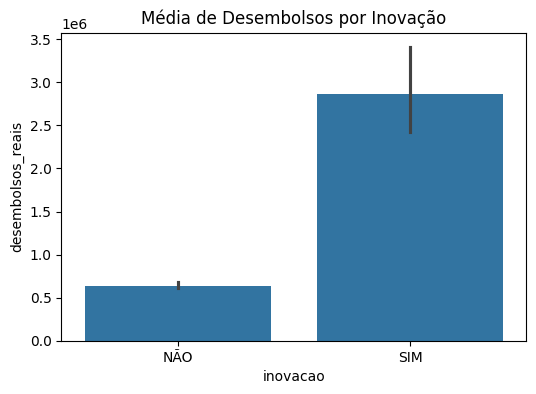

In [37]:
""" Visualização da média de destinação do desembolso com o indicador de inovação.
"""

plt.figure(figsize=(6, 4))

sns.barplot(data=df2, x='inovacao', y='desembolsos_reais').set_title("Média de Desembolsos por Inovação")
plt.show()

## 3. Modelagem

In [39]:
%%time
# features e target
X = df2.drop(columns=['inovacao'])  # Removemos a variável alvo
y = df2['inovacao']

# (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Base de validação a partir do treino (75% treino, 25% validação do conjunto de treino)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Identificar tipos de dados
num_features = ['desembolsos_reais']
cat_features = ['forma_de_apoio', 'produto', 'instrumento_financeiro', 
                'porte_de_empresa', 'regiao', 'setor_cnae', 'setor_bndes']

# transformador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# transformações
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

CPU times: total: 2.84 s
Wall time: 3.73 s


In [40]:
# modelo
clf = DecisionTreeClassifier(max_depth=10, random_state=42).fit(X_train, y_train)

In [41]:
# Avaliar no conjunto de validação
y_val_pred = clf.predict(X_val)
y_val_proba = clf.predict_proba(X_val)[:, 1]

acuracia_val = accuracy_score(y_val, y_val_pred)
gini_val = 2 * acuracia_val - 1

print(f'Acurácia (validação): {acuracia_val:.4f}')
print(f'AUC (validação): {roc_auc_score(y_val, y_val_proba):.4f}')
print(f"Gini (validação): {gini_val:.4f}")

Acurácia (validação): 0.9991
AUC (validação): 0.9026
Gini (validação): 0.9982


In [48]:
# Avaliar no conjunto de teste
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]

acuracia_test = accuracy_score(y_test, y_test_pred)
gini_test = 2 * acuracia_test - 1

print(f'Acurácia (teste): {acuracia_test:.4f}')
print(f'AUC (teste): {roc_auc_score(y_test, y_test_proba):.4f}')
print(f"Gini (teste): {gini_test:.4f}")

Acurácia (teste): 0.9992
AUC (teste): 0.9091
Gini (teste): 0.9983


## 4. Avaliação

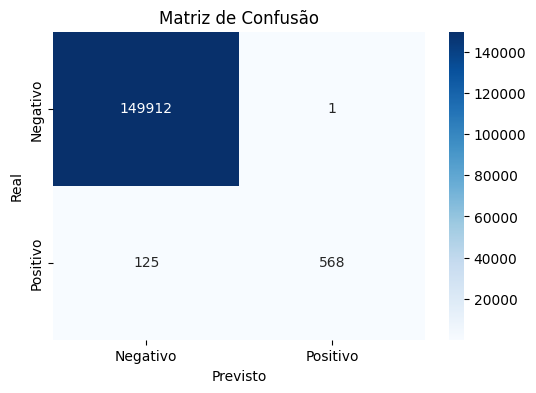

In [52]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### 4.1. Os resultados do modelo de classificação são:

1. **Acurácia:**
- Validação: 0.9991
- Teste: 0.9992

A acurácia está muito alta, o que sugere que o modelo tem uma taxa de acerto de quase 100%, tanto nos dados de validação quanto nos de teste. Isso é um bom sinal de que o modelo está acertando na maioria das previsões.

2. **AUC:**
- Validação: 0.9026
- Teste: 0.9091

Valores acima de 0.9 indicando que o modelo tem uma boa capacidade de discriminação, tanto para validação quanto para teste.

3. **Índice de Gini:**
- Validação: 0.9982
- Teste: 0.9983

O índice de Gini é uma métrica derivada da AUC e, portanto, segue o mesmo padrão. Valores próximos a 1 indicam que o modelo é eficaz na separação das classes.

### 4.2. Matriz de Confusão:
A matriz de confusão mostra que o modelo tem poucos falsos positivos (FP = 1) e falsos negativos (FN = 125), o que indica que ele está fazendo poucas previsões erradas.

O que preocupa na avaliação são os Falsos Negativos (125). Talvez precise de um modelo ajustado para reduzir os FN, contudo no contexto desta análise os resultados são satisfatórios.

### 4.3. Top 10 Variáveis Importantes

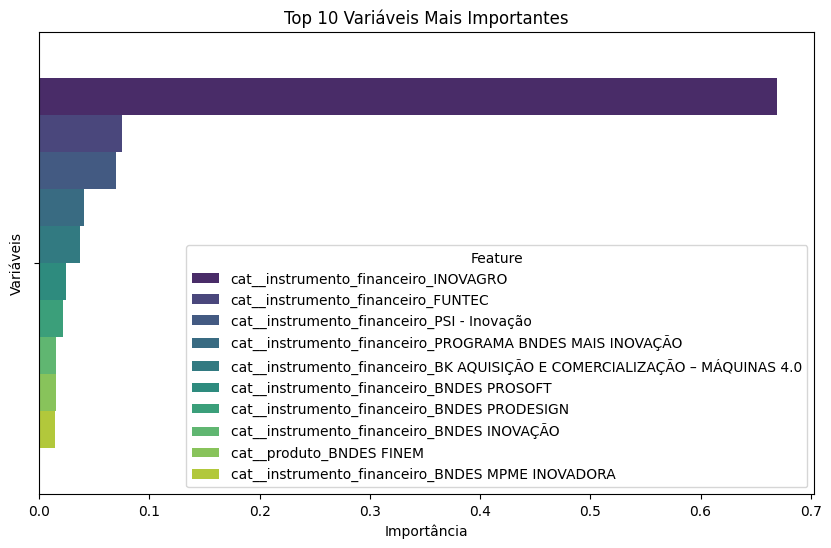

In [58]:
# nomes das features após transformação
feature_names = preprocessor.get_feature_names_out()

importances = clf.feature_importances_

# df ordenado pela importância
feature_importance_df = (pd.DataFrame({'Feature': feature_names, 'Importance': importances})
                         .sort_values(by='Importance', ascending=False))

top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', hue='Feature', palette='viridis')
plt.title(f'Top {top_n} Variáveis Mais Importantes')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.show()

A análise das variáveis mais importantes no modelo de classificação mostra que a categoria "instrumento financeiro" tem muita relevância na previsão de inovação. O destaque vai para o "INOVAGRO", que se sobressai com 67% de importância, indicando uma forte relação entre esse instrumento e a inovação.

---

## Fontes sobre o tema

- [Instrumentos de financiamento](https://www.bndes.gov.br/wps/portal/site/home/financiamento/guia/instrumentos-de-financiamento)
- [Inovagro - Programa de Incentivo à Inovação Tecnológica na Produção Agropecuária](https://www.bndes.gov.br/wps/portal/site/home/financiamento/produto/inovagro)
- [BNDES Funtec - Fundo de desenvolvimento técnico-científico - BNDES Apoio à Inovação](https://www.bndes.gov.br/wps/portal/site/home/financiamento/produto/bndes-funtec)

**Autoria**

🔗 [GitHub - Adrielle Clemente](https://github.com/adrielleClemente)